# Prototype 02
#### Tasks
##### Done

## Training on Google Collab 

In [1]:
# Mount your google drive in google colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

ModuleNotFoundError: No module named 'google'

In [ ]:
# Go to base directory
%cd /content/drive/MyDrive/University/Master-Thesis/Code

## Training on Local Machine

In [1]:
import os

original_working_directory_path = os.getcwd()
print("The original working directory is {0}".format(os.getcwd()))

def to_original_working_directory():
    os.chdir(original_working_directory_path)
    print(f"Changed to original working directory {original_working_directory_path}")

The original working directory is /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02


In [2]:
def to_root_working_directory():
    root_working_directory_path = os.path.join(original_working_directory_path, "../..")
    os.chdir(root_working_directory_path)
    print(f"Changed to root working directory {os.getcwd()}")

In [3]:
to_root_working_directory()

Changed to root working directory /Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code


In [4]:
# Validate that python 3.10 is used
!python --version

Python 3.10.10


In [7]:
def seed_random():
    random.seed(42)
    torch.random.manual_seed(42)
    np.random.seed(42)

## --- Dependencies ---

In [5]:
# Standard Dependencies
import sys
import os
import numpy as np
from time import time

In [6]:
# Global Dependencies
from src.custom_types import Behavior, MTDTechnique
from src.data_provider import DataProvider
from src.evaluation_utils import plot_learning, seed_random, get_pretrained_agent, evaluate_agent, evaluate_agent_on_afterstates
from src.autoencoder_utils import evaluate_ae_on_no_mtd_behavior, get_pretrained_ae

/Users/jankreischer/opt/anaconda3/envs/FedRL-for-IT-Sec/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from prototypes.prototype_02.sensor_environment import SensorEnvironment
from prototypes.prototype_02.agent import Agent
from prototypes.prototype_02.client import Client
from prototypes.prototype_02.enums import Execution, Evaluation
from prototypes.prototype_02.server import Server
from prototypes.prototype_02.experiment import Experiment

In [11]:
from sklearn.decomposition import PCA

train_data_pca, test_data_pca, _ = DataProvider.get_flat_train_test_split(pi=3, scale_normal_only=False)
print(train_data_pca.shape)
print(test_data_pca.shape)

(37428, 47)
(11718, 47)


In [85]:
import matplotlib.pyplot as plt

X_train_std = train_data_pca[:, :-1]

pca = PCA(n_components=14)
pca.fit(train_data_pca_x)
X_train_pca = pca.fit_transform(X_train_std)

# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

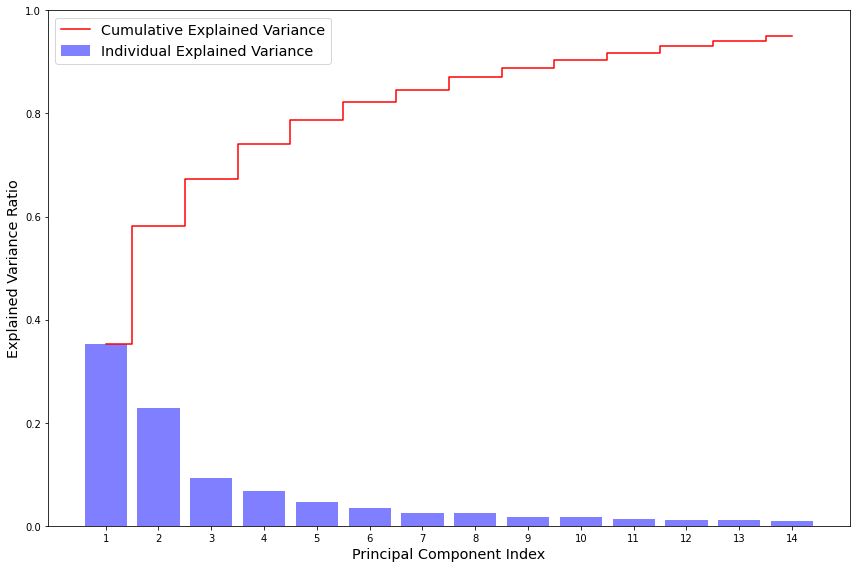

In [96]:
#
# Create the visualization plot
#
fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xticks(range(1, len(exp_var_pca)+1, 1))
plt.yticks(np.linspace(0,1,6))
plt.ylim(0,1)
plt.bar(range(1,len(exp_var_pca)+1), exp_var_pca, alpha=0.5, align='center', color='blue', label='Individual Explained Variance')
plt.step(range(1,len(cum_sum_eigenvalues)+1), cum_sum_eigenvalues, where='mid', color='red', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio', fontsize=fontsize)
plt.xlabel('Principal Component Index', fontsize=fontsize)
plt.legend(loc='best', fontsize=fontsize)
plt.tight_layout()
plt.show()

In [21]:
print(cum_sum_eigenvalues)

[0.35236475 0.58118324 0.67309289 0.73991876 0.78664383 0.82150344
 0.84607473 0.86994344 0.88729345 0.90427583 0.91802861 0.93021734
 0.94073695 0.95058111 0.95872159]


In [36]:
cumulative_explained_variances = {}

for n_components in range (1, 21):
    pca = PCA(n_components=n_components)
    pca.fit(train_data_pca_x)
    X_train_pca = pca.fit_transform(X_train_std)
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.sum(explained_variance)
    cumulative_explained_variances[n_components] = cumulative_explained_variance

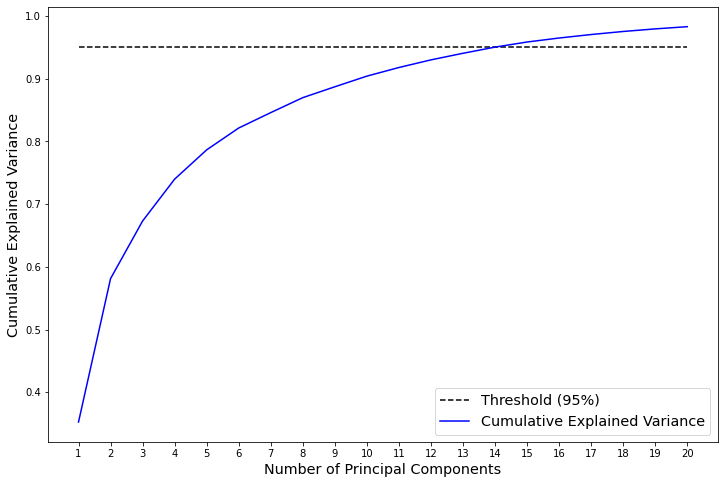

In [100]:
x = list(cumulative_explained_variances.keys())
y = list(cumulative_explained_variances.values())

fontsize = 'x-large'
plt.figure(figsize=(12, 8))
plt.xlabel('Number of Principal Components', fontsize=fontsize)
plt.ylabel('Cumulative Explained Variance', fontsize=fontsize)
plt.xticks(x)
#plt.ylim(0,1)
#plt.axhline(y=0.95, color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, [0.95]*len(x), color='black', linestyle='dashed', label='Threshold (95%)')
plt.plot(x, y, color='blue', label='Cumulative Explained Variance')
plt.legend(loc='lower right', fontsize=fontsize)
plt.show()

In [41]:
cumulative_explained_variances

{1: 0.3523647549593535,
 2: 0.5811832414015312,
 3: 0.673092892678218,
 4: 0.739918755234889,
 5: 0.7866438137851377,
 6: 0.8215034347229032,
 7: 0.8460746900206978,
 8: 0.8699434429187485,
 9: 0.8872934488334119,
 10: 0.9042758318786142,
 11: 0.9180285912197849,
 12: 0.9302173407209806,
 13: 0.9407369503348323,
 14: 0.950581104621539,
 15: 0.9587215950451,
 16: 0.965091447818696,
 17: 0.9706601202712388,
 18: 0.975532820798746,
 19: 0.9796722314557519,
 20: 0.9831779970727698}

In [35]:
print(y)

[0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747, 0.9831779969676747]


In [ ]:

#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## --- Hyperparameters ---

In [12]:
# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
LOG_FREQ = 100
DIMS = 20
PI = 3
SAMPLES = 10

In [12]:
import os
import sys
import numpy as np
from src.autoencoder import AutoEncoder, AutoEncoderInterpreter
import torch
from src.evaluation_utils import calculate_metrics, check_anomalous
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate



experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

seed_random()

def split_data(data, split=0.8):
    row = int(len(data) * split)
    X_train = data[:row, :-1].astype(np.float32)
    X_valid = data[row:, :-1].astype(np.float32)

    return X_train, X_valid

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)

train_data[b] = normal_data[:int(l * s)]  # use fixed number of samples for Reinforcement Agent training
# COMMENT/UNCOMMENT BELOW for pretraining of autoencoder

ae_data = normal_data[int(l * s):]  # use remaining samples for autoencoder
ae_train_x, ae_valid_x = split_data(ae_data)

flattend_test_data = np.empty([0,47])
for behavior, behavior_data in test_data.items():
    print(f"{behavior}: {len(behavior_data)} samples")
    
    if behavior == Behavior.NORMAL:
        n_samples = 2800
        behavior_data[:, -1] =  0
    else:
        n_samples = 400
        behavior_data[:, -1] = 1
    y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * n_samples)
    
    flattend_test_data = np.concatenate((flattend_test_data, behavior_data[:n_samples]), axis=0)

ae_test_x = flattend_test_data[:,:-1]
print(f"type(ae_test_x) = {type(ae_test_x)}")
print(f"ae_test_x.dtype = {ae_test_x.dtype}")
ae_test_y = flattend_test_data[:,-1].astype(int)
print(f"type(ae_test_y) = {type(ae_test_y)}")
print(f"ae_test_y.dtype = {ae_test_y.dtype}")

print(f"Training Data: X.shape = {ae_train_x.shape}")
#print(f"Validation Data: X.shape = {ae_valid_x.shape}")   
print(f"Test Data: X.shape = {ae_test_x.shape}; y.shape = {ae_test_y.shape}")

evaluation_data = {}
for behavior, behavior_data in train_data.items():
    print(f"{behavior}: {len(behavior_data)} samples")
    if behavior == Behavior.NORMAL:
        evaluation_data[behavior] = behavior_data[:2800]
    else:
        evaluation_data[behavior] = behavior_data[:400]

Behavior.NORMAL: 2930 samples
Behavior.RANSOMWARE_POC: 1866 samples
Behavior.ROOTKIT_BDVL: 1129 samples
Behavior.ROOTKIT_BEURK: 1461 samples
Behavior.CNC_THETICK: 1531 samples
Behavior.CNC_BACKDOOR_JAKORITAR: 852 samples
Behavior.CNC_OPT1: 1127 samples
Behavior.CNC_OPT2: 822 samples
type(ae_test_x) = <class 'numpy.ndarray'>
ae_test_x.dtype = object
type(ae_test_y) = <class 'numpy.ndarray'>
ae_test_y.dtype = int64
Training Data: X.shape = (5375, 46)
Test Data: X.shape = (5600, 46); y.shape = (5600,)
Behavior.NORMAL: 2879 samples
Behavior.RANSOMWARE_POC: 6181 samples
Behavior.ROOTKIT_BDVL: 3406 samples
Behavior.ROOTKIT_BEURK: 4744 samples
Behavior.CNC_THETICK: 4952 samples
Behavior.CNC_BACKDOOR_JAKORITAR: 2380 samples
Behavior.CNC_OPT1: 3655 samples
Behavior.CNC_OPT2: 2544 samples


In [ ]:
from torch import nn
from skorch import NeuralNetClassifier
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

def auto_encoder_architecture_01(in_features: int, activation_function):
    nn_l1 = 20
    nn_l2 = 10
    nn_l3 = 5
    
    '''
    modules = []
    modules.append(nn.Linear(in_features, nn_l1))
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l1)),
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, in_features)),
    modules.append(activation_function)
    model = nn.Sequential(*modules)
    '''
    
    #model = nn.Sequential(
    #    nn.Linear(in_features, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, in_features),
    #    nn.GELU()
    #)
    nn_bottleneck = 8
    model = nn.Sequential(
        nn.Linear(in_features, nn_bottleneck),
        nn.GELU(),
        nn.Linear(nn_bottleneck, in_features),
        nn.GELU(),
    )
    return model


class OldAutoEncoder(torch.nn.Module):
    

    def __init__(self, model, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):

        super().__init__()
        
        '''
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
            #torch.from_numpy(train_y).type(torch.float)
        )
        self.training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        '''
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)


        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        
        self.num_stds = num_stds
        
        
        n_features = X_test.shape[1]
        #self.model =  auto_encoder_architecture_01(n_features, activation_function)
        '''
        nn_l1 = 24
        nn_l2 = 12
        #nn_l3 = 6
        #nn_l4 = 4
        self.model = nn.Sequential(
            nn.Linear(n_features, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, nn_l2),
            activation_function,
            #nn.Linear(nn_l2, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l4),
            #activation_function,
            #nn.Linear(nn_l4, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l2),
            #activation_function,
            nn.Linear(nn_l2, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, n_features),
            activation_function,
        )'''
        self.model = model
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None
        
        self.verbose = verbose

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, X_train, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='sum'), num_epochs: int = 15, batch_size=64, verbose=False):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.model.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if verbose:
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.model.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.model(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.model.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                #batch_x = batch_x  # .cuda()
                model_predictions = self.model(batch_x)

                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        #threshold = self.compute_threshold(num_std)
        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.model.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.model(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        if self.verbose:
            print(f"Highest validation accuracy achieved {accuracy:.2f} with num_std={num_std}")
            self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            #if self.verbose:
            #    print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std=0.1, tablefmt='pipe'):
        results = []
        labels= [0,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=num_std)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', f"\\{n_samples}"])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print("-----------")
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "#Samples"], tablefmt=tablefmt)) 

In [137]:
from torch import nn
from skorch import NeuralNetClassifier
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, accuracy_score

def auto_encoder_architecture_01(in_features: int, activation_function):
    nn_l1 = 20
    nn_l2 = 10
    nn_l3 = 5
    
    '''
    modules = []
    modules.append(nn.Linear(in_features, nn_l1))
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l3)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l3, nn_l2)),
    modules.append(activation_function),
    modules.append(nn.Dropout(p=0.2)),
    modules.append(nn.Linear(nn_l2, nn_l1)),
    modules.append(nn.BatchNorm1d(nn_l1)),
    modules.append(activation_function),
    modules.append(nn.Linear(nn_l1, in_features)),
    modules.append(activation_function)
    model = nn.Sequential(*modules)
    '''
    
    #model = nn.Sequential(
    #    nn.Linear(in_features, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l3),
    #    nn.GELU(),
    #    nn.Linear(nn_l3, nn_l2),
    #    nn.GELU(),
    #    nn.Linear(nn_l2, nn_l1),
    #    nn.BatchNorm1d(nn_l1),
    #    nn.GELU(),
    #    nn.Linear(nn_l1, in_features),
    #    nn.GELU()
    #)
    nn_bottleneck = 8
    model = nn.Sequential(
        nn.Linear(in_features, nn_bottleneck),
        nn.GELU(),
        nn.Linear(nn_bottleneck, in_features),
        nn.GELU(),
    )
    return model


class AutoEncoder(torch.nn.Module):
    

    def __init__(self, model, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):

        super().__init__()
        
        '''
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
            #torch.from_numpy(train_y).type(torch.float)
        )
        self.training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
        '''
        
        validation_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_valid).type(torch.float),

        )
        self.validation_data_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=1, shuffle=True, drop_last=True)


        self.X_test = X_test
        self.y_test = y_test
        
        self.evaluation_data = evaluation_data
        
        self.num_stds = num_stds
        
        
        n_features = X_test.shape[1]
        #self.model =  auto_encoder_architecture_01(n_features, activation_function)
        '''
        nn_l1 = 24
        nn_l2 = 12
        #nn_l3 = 6
        #nn_l4 = 4
        self.model = nn.Sequential(
            nn.Linear(n_features, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, nn_l2),
            activation_function,
            #nn.Linear(nn_l2, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l4),
            #activation_function,
            #nn.Linear(nn_l4, nn_l3),
            #activation_function,
            #nn.Linear(nn_l3, nn_l2),
            #activation_function,
            nn.Linear(nn_l2, nn_l1),
            nn.BatchNorm1d(nn_l1),
            activation_function,
            nn.Linear(nn_l1, n_features),
            activation_function,
        )'''
        self.model = model
        self.threshold = None
        self.loss_mean = None
        self.loss_standard_deviation = None
        
        self.verbose = verbose

        
    def forward(self, X):
        return self.model(X)
    
    
    def pretrain(self, X_train, optimizer=torch.optim.SGD, loss_function=torch.nn.MSELoss(reduction='sum'), num_epochs: int = 15, batch_size=64, verbose=False):
        
        training_dataset = torch.utils.data.TensorDataset(
            torch.from_numpy(X_train).type(torch.float),
        )
        training_data_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

        epoch_losses = []
        #for e in tqdm(range(num_epochs), unit="epoch", leave=False):
        for e in range(num_epochs):
            self.train()
            current_losses = []
            for batch_index, (inputs,) in enumerate(training_data_loader):
                optimizer.zero_grad()
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                loss.backward()
                optimizer.step()
                current_losses.append(loss.item())
            
            epoch_losses.append(np.average(current_losses))
            if verbose:
                print(f'Training Loss in epoch {e + 1}: {epoch_losses[e]}')
            
        self.analyze_loss()

    '''
    This function uses normal data samles 
    after training the autoencoder to determine
    values that can be considered normal
    for the reconstruction loss based on normal samples
    '''
    def analyze_loss(self):
        losses = []
        
        self.eval() 
        with torch.no_grad():
            loss_function = torch.nn.MSELoss(reduction='sum')
            for batch_index, (inputs,) in enumerate(self.validation_data_loader):
                outputs = self.forward(inputs)
                loss = loss_function(inputs, outputs)
                losses.append(loss.item())
        
        losses = np.array(losses)

        self.loss_mean = losses.mean()
        self.loss_standard_deviation = losses.std()

        
    def predict(self, x, num_std = 1):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        all_predictions = torch.tensor([])  # .cuda()

        self.eval()
        with torch.no_grad():
            ae_loss = torch.nn.MSELoss(reduction="sum")
            for idx, (batch_x,) in enumerate(test_data_loader):
                #batch_x = batch_x  # .cuda()
                model_predictions = self.forward(batch_x)

                model_predictions = ae_loss(model_predictions, batch_x).unsqueeze(0)  # unsqueeze as batch_size set to 1
                all_predictions = torch.cat((all_predictions, model_predictions))

        #threshold = self.compute_threshold(num_std)
        threshold = self.loss_mean + num_std * self.loss_standard_deviation
        all_predictions = (all_predictions > threshold).type(torch.long)
        return all_predictions.flatten()
    
    
    def predict_deviation(self, x):
        test_data = torch.utils.data.TensorDataset(
            torch.from_numpy(x).type(torch.float32)
        )
        test_data_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)

        prediction_errors = torch.tensor([])
        loss_function = torch.nn.MSELoss(reduction="sum")
        
        self.eval()
        with torch.no_grad():
            
            for batch_index, (inputs,) in enumerate(test_data_loader):
                prediction = self.forward(inputs)
                prediction_error = loss_function(inputs, prediction).unsqueeze(0)  # unsqueeze as batch_size set to 1
                prediction_errors = torch.cat((prediction_errors, prediction_error))

        return prediction_errors
    
    
    def score(self):
        num_std, accuracy = self.accuracy_score(None, None)
        if self.verbose:
            print(f"Highest validation accuracy achieved {accuracy:.2f} with num_std={num_std}")
            self.evaluate(num_std)
        return accuracy
    
    
    def accuracy_score(self, X, y):
        #if not self.threshold:
        #loss_mean, loss_standard_deviation = self.analyze_loss(X)
        #num_stds = np.arange(0.1, 3, 0.1)
        if self.loss_mean == None or self.loss_standard_deviation == None:
              #print("accuracy_score_optimized > accurcy_loss()")
              self.analyze_loss()
    
        best_accuracy = 0
        best_num_std = 0
        #accuracies = []
        y_dev = self.predict_deviation((self.X_test).astype(np.float32))
        for num_std in self.num_stds:
            y_true = self.y_test
            threshold = self.loss_mean + num_std * self.loss_standard_deviation
            y_pred = (y_dev > threshold).type(torch.long).detach().cpu().numpy()
            
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_num_std = num_std
            #if self.verbose:
            #    print(f"num_std {num_std:.2f} -> accuracy: {accuracy}")

        return best_num_std, best_accuracy
    
    
    def evaluate(self, num_std=0.1, tablefmt='pipe'):
        results = []
        labels= [0,1]
        pos_label = 1
        
        y_true_total = np.empty([0])
        y_pred_total = np.empty([0])
        for behavior, data in self.evaluation_data.items():
            y_true = np.array([0 if behavior == Behavior.NORMAL else 1] * len(data)).astype(int)
            y_true_total = np.concatenate((y_true_total, y_true))

            y_pred = self.predict(data[:, :-1].astype(np.float32), num_std=num_std)
            y_pred_total = np.concatenate((y_pred_total, y_pred))

            accuracy = accuracy_score(y_true, y_pred)

            n_samples = len(y_true)
            results.append([behavior.name.replace("_", "\_"), f'{(100 * accuracy):.2f}\%', '\\notCalculated', '\\notCalculated', '\\notCalculated', f"\\{n_samples}"])

        accuracy = accuracy_score(y_true_total, y_pred_total)
        precision = precision_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        recall = recall_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        f1 = f1_score(y_true_total, y_pred_total, average='binary', labels=labels, pos_label=pos_label, zero_division=1)
        n_samples = len(y_true_total)
        results.append(["GLOBAL", f'{(100 * accuracy):.2f}\%', f'{(100 * precision):.2f}\%', f'{(100 * recall):.2f}\%', f'{(100 * f1):.2f}\%', n_samples])
        print("-----------")
        print(tabulate(results, headers=["Behavior", "Accuracy", "Precision", "Recall", "F1-Score", "#Samples"], tablefmt=tablefmt)) 

In [125]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data, [0.1], torch.nn.GELU(), 64)

In [351]:
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-5, momentum=0.9), num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 317.6852937261742
Training Loss in epoch 2: 140.78509503100292
Training Loss in epoch 3: 84.27301549336997
Training Loss in epoch 4: 67.53299993492034
Training Loss in epoch 5: 60.213375918836476
Training Loss in epoch 6: 55.81555759475892
Training Loss in epoch 7: 53.005501896502025
Training Loss in epoch 8: 50.47457485888378
Training Loss in epoch 9: 49.33269362851798
Training Loss in epoch 10: 46.891456925725365
Training Loss in epoch 11: 46.02061531342656
Training Loss in epoch 12: 43.344994510512755
Training Loss in epoch 13: 42.54700669897608
Training Loss in epoch 14: 38.9901105811797
Training Loss in epoch 15: 38.47361150994358
Training Loss in epoch 16: 36.86675363563629
Training Loss in epoch 17: 37.07250608880836
Training Loss in epoch 18: 35.504834692162206
Training Loss in epoch 19: 35.09483505157103
Training Loss in epoch 20: 35.04106608930841
Training Loss in epoch 21: 33.42888737873859
Training Loss in epoch 22: 33.137062808117236
Training Loss

In [352]:
autoencoder.evaluate(tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   #Samples \\
\hline
 NORMAL                   & 47.07\%    & \notCalculated & \notCalculated & \notCalculated &       2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 ROOTKIT\_BEURK           & 98.00\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_THETICK             & 72.25\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_BACKDOOR\_JAKORITAR & 98.00\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400

In [126]:
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-5, momentum=0.9), num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 303.39006649155215
Training Loss in epoch 2: 156.2397525281791
Training Loss in epoch 3: 112.73082604465715
Training Loss in epoch 4: 91.07132555490517
Training Loss in epoch 5: 84.81896154564548
Training Loss in epoch 6: 78.31640473331314
Training Loss in epoch 7: 72.69140588231834
Training Loss in epoch 8: 70.64134570202195
Training Loss in epoch 9: 67.32544308398144
Training Loss in epoch 10: 65.3132519090032
Training Loss in epoch 11: 63.923421147357985
Training Loss in epoch 12: 62.10176100213844
Training Loss in epoch 13: 61.22547236982599
Training Loss in epoch 14: 59.718266176890175
Training Loss in epoch 15: 58.049342511648156
Training Loss in epoch 16: 58.197935265230846
Training Loss in epoch 17: 57.089933510286265
Training Loss in epoch 18: 56.30783352219915
Training Loss in epoch 19: 55.59447359751506
Training Loss in epoch 20: 54.58460984747094
Training Loss in epoch 21: 53.34547989626965
Training Loss in epoch 22: 53.1217877491411
Training Loss 

In [127]:
autoencoder.evaluate(tablefmt='latex_raw')

-----------
\begin{tabular}{llllll}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       & #Samples   \\
\hline
 NORMAL                   & 79.79\%    & \notCalculated & \notCalculated & \notCalculated & \2800      \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BEURK           & 46.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_THETICK             & 37.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_BACKDOOR\_JAKORITAR & 35.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400      

## Initial Architecture Evaluation

In [124]:
def initial_autoencoder_architecture():
    return nn.Sequential(
        nn.Linear(46, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 11),
        nn.GELU(),
        nn.Linear(11, 23),
        nn.BatchNorm1d(23),
        nn.GELU(),
        nn.Linear(23, 46),
        nn.GELU()
    )

initial_autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)

In [383]:
initial_autoencoder.pretrain(ae_train_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-4, momentum=0.9), num_epochs=100, batch_size=64, verbose=False)

In [384]:
initial_autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

-----------
\begin{tabular}{llllll}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       & #Samples   \\
\hline
 NORMAL                   & 96.96\%    & \notCalculated & \notCalculated & \notCalculated & \2800      \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BDVL            & 89.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BEURK           & 4.00\%     & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_THETICK             & 3.00\%     & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_BACKDOOR\_JAKORITAR & 0.25\%     & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT1                & 31.25\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400      

## Tied Architecture Evaluation

In [130]:
tied_autoencoder = AutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, num_stds=[num_std=2.5], torch.nn.GELU(), 64)


In [ ]:
tied_autoencoder.pretrain(ae_train_x, optimizer=torch.optim.SGD(autoencoder.parameters(), lr=1e-4, momentum=0.9), num_epochs=100, batch_size=64, verbose=True)

In [129]:
tied_autoencoder.evaluate(t)

| Behavior                        | Accuracy   | Precision   | Recall   | F1-Score   |   #Samples |
|:--------------------------------|:-----------|:------------|:---------|:-----------|-----------:|
| Behavior.NORMAL                 | 55.00%     | 100.00%     | 55.00%   | 70.97%     |       2800 |
| Behavior.RANSOMWARE_POC         | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |
| Behavior.ROOTKIT_BDVL           | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |
| Behavior.ROOTKIT_BEURK          | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |
| Behavior.CNC_THETICK            | 58.25%     | 100.00%     | 58.25%   | 73.62%     |        400 |
| Behavior.CNC_BACKDOOR_JAKORITAR | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |
| Behavior.CNC_OPT1               | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |
| Behavior.CNC_OPT2               | 100.00%    | 100.00%     | 100.00%  | 100.00%    |        400 |


## Hyperparameter Search

In [334]:
import skorch
from skorch import NeuralNet, NeuralNetRegressor
from skorch.scoring import loss_scoring

class StateAnomalyDetector(skorch.NeuralNet):
    def score(self, X, y=None):
        return self.module_.score()
    
    def evaluate(self):
        self.module_.evaluate()

In [335]:
from skorch import NeuralNet, NeuralNetRegressor
from skorch.callbacks import LRScheduler, EarlyStopping

model = StateAnomalyDetector(
    module=AutoEncoder,
    
    criterion=torch.nn.MSELoss(reduction='mean'),
    optimizer=torch.optim.SGD,
    optimizer__lr=0.0001,
    optimizer__weight_decay=0.01,
    
    iterator_train__shuffle=True,
    max_epochs=20,
    batch_size=32,
    
    module__model=initial_autoencoder_architecture(),
    module__X_valid=ae_valid_x,
    module__X_test=ae_test_x,
    module__y_test=ae_test_y,
    module__evaluation_data=evaluation_data,
    module__activation_function=nn.GELU(),
    module__num_stds=np.linspace(0.1, 3, 30),
    module__verbose=False,
    
    verbose=True,
    
    callbacks=[EarlyStopping(patience=5, monitor='valid_loss')]

)

In [293]:
model.fit(ae_train_x, ae_train_x);

Re-initializing module because the following parameters were re-set: X_test, X_valid, activation_function, evaluation_data, model, num_stds, verbose, y_test.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1524        0.1589  0.2618
      2        0.1526        0.1563  0.2091
      3        0.1521        0.1566  0.1984
      4        0.1523        0.1562  0.1992
      5        0.1519        0.1578  0.2014
      6        0.1515        0.1625  0.2069
      7        0.1513        0.1553  0.1966
      8        0.1514        0.1562  0.2120
      9        0.1513        0.1567  0.2148
     10        0.1509        0.1623  0.2167
     11        0.1508        0.1568  0.2428
Stopping since valid_loss has not improved in the last 5 epochs.


In [296]:
model.module_.evaluate()

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [336]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        self.eps = eps
        
    def forward(self, yhat, y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [338]:
from torch.optim.lr_scheduler import StepLR

#scheduler = StepLR(optimizer, 
#                   step_size = 4, # Period of learning rate decay
#                   gamma = 0.5) # Multiplicative factor of learning rate decay



from sklearn.model_selection import GridSearchCV
param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    #'optimizer__weight_decay': [0.00001],
    #'scheduler': [StepLR( 
    #               step_size = 4, # Period of learning rate decay
    #               gamma = 0.5)],
    'lr': [0.0001, 0.00001],
    'optimizer__weight_decay': [0.01],
    #'lr' : [0.0001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
    'module__verbose': [True]
}

grid_search_01 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=10, refit=True)
grid_search_01_result = grid_search_01.fit(ae_train_x, ae_train_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), module__verbose=True, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.01, verbose=False
Highest validation accuracy achieved 0.72 with num_std=3.0
-----------
| Behavior               | Accuracy   | Precision      | Recall         | F1-Score       |   #Samples |
|:-----------------------|:-----------|:---------------|:---------------|:---------------|-----------:|
| NORMAL                 | 96.39%     | \notCalculated | \notCalculated | \notCalculated |       2800 |
| RANSOMWARE_POC         | 100.00%    | \notCalculated | \notCalculated | \notCalculated |        400 |
| ROOTKIT_BDVL           | 100.00%    | \notCalculated | \notCalculated | \notCalculated |        400 |
| ROOTKIT_BEURK          | 5.50%      | \notCalculated | \notCalculated | \notCalcul

In [341]:
print(" Results from Grid Search 01" )
print("\n The best score across ALL searched params:\n", grid_search_01.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search_01.best_params_)

 Results from Grid Search 01

 The best score across ALL searched params:
 0.7233928571428572

 The best parameters across ALL searched params:
 {'batch_size': 64, 'criterion': <class '__main__.RMSELoss'>, 'lr': 0.0001, 'max_epochs': 20, 'module__activation_function': GELU(approximate='none'), 'module__verbose': True, 'optimizer': <class 'torch.optim.adam.Adam'>, 'optimizer__weight_decay': 0.01, 'verbose': False}


In [353]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)
autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

Training Loss in epoch 1: 0.37115588389247295
Training Loss in epoch 2: 0.34878160903252753
Training Loss in epoch 3: 0.32624133020998486
Training Loss in epoch 4: 0.30229294695049885
Training Loss in epoch 5: 0.2785998299179307
Training Loss in epoch 6: 0.25604384850306683
Training Loss in epoch 7: 0.23544601880642305
Training Loss in epoch 8: 0.21550859780196685
Training Loss in epoch 9: 0.19728003891117601
Training Loss in epoch 10: 0.18221662848828787
Training Loss in epoch 11: 0.16925879020288767
Training Loss in epoch 12: 0.15677789823118463
Training Loss in epoch 13: 0.14816203785229878
Training Loss in epoch 14: 0.14002011168793024
Training Loss in epoch 15: 0.13491134309625052
Training Loss in epoch 16: 0.13139398629406848
Training Loss in epoch 17: 0.12654616154101958
Training Loss in epoch 18: 0.1232162870197411
Training Loss in epoch 19: 0.12110543628054929
Training Loss in epoch 20: 0.11759546291397278
Training Loss in epoch 21: 0.11599518466426666
Training Loss in epoch 2

In [377]:
autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

-----------
\begin{tabular}{lllllr}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       &   #Samples \\
\hline
 NORMAL                   & 84.79\%    & \notCalculated & \notCalculated & \notCalculated &       2800 \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 ROOTKIT\_BEURK           & 45.75\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_THETICK             & 47.25\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_BACKDOOR\_JAKORITAR & 40.75\%    & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_OPT1                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400 \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated &        400

In [378]:
print(experiment_path)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02/experiments/experiment_01


In [ ]:
grid_search_01 = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=10, refit=True)
grid_search_01_result = grid_search_01.fit(ae_train_x, ae_train_x)

In [319]:
from torch.optim.lr_scheduler import StepLR

#scheduler = StepLR(optimizer, 
#                   step_size = 4, # Period of learning rate decay
#                   gamma = 0.5) # Multiplicative factor of learning rate decay



from sklearn.model_selection import GridSearchCV
param_grid = {
    'verbose': [False],
    'criterion': [RMSELoss, torch.nn.L1Loss, torch.nn.MSELoss],
    'optimizer': [torch.optim.Adam, torch.optim.SGD, torch.optim.RMSprop],
    #'optimizer__weight_decay': [0.00001],
    #'scheduler': [StepLR( 
    #               step_size = 4, # Period of learning rate decay
    #               gamma = 0.5)],
    'lr': [0.0001, 0.00001],
    'optimizer__weight_decay': [0.01],
    #'lr' : [0.0001],
    'max_epochs': [20],
    'batch_size': [64],
    #'module__activation_function': [torch.nn.Tanh(), torch.nn.GELU(), torch.nn.ReLU(), torch.nn.Sigmoid(), torch.nn.ELU()],
    'module__activation_function': [torch.nn.GELU()],
    'module__verbose': [False]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, cv=3, verbose=10, refit=True)
grid_search_result = grid_search.fit(ae_train_x, ae_train_x)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3; 1/18] START batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), module__verbose=False, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.01, verbose=False
Evaluation performed with best num_std=2.8
[CV 1/3; 1/18] END batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), module__verbose=False, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.01, verbose=False;, score=0.724 total time=   3.6s
[CV 2/3; 1/18] START batch_size=64, criterion=<class '__main__.RMSELoss'>, lr=0.0001, max_epochs=20, module__activation_function=GELU(approximate='none'), module__verbose=False, optimizer=<class 'torch.optim.adam.Adam'>, optimizer__weight_decay=0.01, verbose=False
Evaluation performed with best num_std=2.6999999999999997
[CV 2/3; 1/1

In [322]:
import pandas as pd
grid_search_cv_results = pd.DataFrame(grid_search.cv_results_)
grid_search_cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_criterion,param_lr,param_max_epochs,param_module__activation_function,param_module__verbose,param_optimizer,param_optimizer__weight_decay,param_verbose,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,1.902753,0.015908,1.649022,0.010600,64,<class '__main__.RMSELoss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.adam.Adam'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.723571,0.723393,0.721964,0.722976,0.000719,1
1,0.477055,0.007919,1.715309,0.110713,64,<class '__main__.RMSELoss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.sgd.SGD'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.701250,0.701607,0.700179,0.701012,0.000607,13
2,1.808321,0.086823,1.836134,0.053354,64,<class '__main__.RMSELoss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.721250,0.719107,0.723214,0.721190,0.001677,4
3,2.061119,0.071359,1.666123,0.023894,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),False,<class 'torch.optim.adam.Adam'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.723214,0.721607,0.720714,0.721845,0.001034,2
4,0.495560,0.011581,1.842341,0.147369,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),False,<class 'torch.optim.sgd.SGD'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.701607,0.700179,0.700714,0.700833,0.000589,14
5,1.894194,0.161063,1.729109,0.056534,64,<class '__main__.RMSELoss'>,0.00001,20,GELU(approximate='none'),False,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False,"{'batch_size': 64, 'criterion': <class '__main...",0.721607,0.718214,0.724821,0.721548,0.002698,3
6,2.074412,0.100396,1.885335,0.103601,64,<class 'torch.nn.modules.loss.L1Loss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.adam.Adam'>,0.01,False,"{'batch_size': 64, 'criterion': <class 'torch....",0.718750,0.721607,0.721607,0.720655,0.001347,5
7,0.506441,0.003224,1.738670,0.045885,64,<class 'torch.nn.modules.loss.L1Loss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.sgd.SGD'>,0.01,False,"{'batch_size': 64, 'criterion': <class 'torch....",0.700000,0.699821,0.698929,0.699583,0.000469,18
8,1.892262,0.055496,2.035933,0.212426,64,<class 'torch.nn.modules.loss.L1Loss'>,0.0001,20,GELU(approximate='none'),False,<class 'torch.optim.rmsprop.RMSprop'>,0.01,False,"{'batch_size': 64, 'criterion': <class 'torch....",0.717857,0.719464,0.719107,0.718810,0.000689,7
9,2.283452,0.227247,1.792792,0.086659,64,<class 'torch.nn.modules.loss.L1Loss'>,0.00001,20,GELU(approximate='none'),False,<class 'torch.optim.adam.Adam'>,0.01,False,"{'batch_size': 64, 'criterion': <class 'torch....",0.719107,0.721429,0.721429,0.720655,0.001094,5


In [321]:
print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n", grid_search.best_estimator_)
print("\n The best score across ALL searched params:\n", grid_search.best_score_)
print("\n The best parameters across ALL searched params:\n", grid_search.best_params_)

 Results from Grid Search 

 The best estimator across ALL searched params:
 <class '__main__.StateAnomalyDetector'>[initialized](
  module_=AutoEncoder(
    (model): Sequential(
      (0): Linear(in_features=46, out_features=23, bias=True)
      (1): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=23, out_features=11, bias=True)
      (4): GELU(approximate='none')
      (5): Linear(in_features=11, out_features=23, bias=True)
      (6): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU(approximate='none')
      (8): Linear(in_features=23, out_features=46, bias=True)
      (9): GELU(approximate='none')
    )
  ),
)

 The best score across ALL searched params:
 0.7229761904761904

 The best parameters across ALL searched params:
 {'batch_size': 64, 'criterion': <class '__main__.RMSELoss'>, 'lr': 0.0001, 'max_epochs': 20, 'module__activation_funct

In [140]:
import numpy as np
import torch.nn.functional as F

from torch import nn

class TiedAutoEncoder(AutoEncoder):
    

    def __init__(self, X_valid, X_test, y_test, evaluation_data, num_stds=[1], activation_function=torch.nn.ReLU(), batch_size: int = 64, verbose=False):
        
        super(TiedAutoEncoder, self).__init__(None, X_valid, X_test, y_test, evaluation_data)

        n_features = X_valid.shape[1]
        self.weight_matrix_1 = nn.Parameter(torch.randn(n_features, 30))
        self.weight_matrix_2 = nn.Parameter(torch.randn(30, 20))
        self.weight_matrix_3 = nn.Parameter(torch.randn(20, 10))
        
        
    def forward(self, x):
        x = F.relu(F.linear(x, self.weight_matrix_1.T))
        x = F.relu(F.linear(x, self.weight_matrix_2.T))
        x = F.relu(F.linear(x, self.weight_matrix_3.T))
        x = F.relu(F.linear(x, self.weight_matrix_3))
        x = F.relu(F.linear(x, self.weight_matrix_2))
        x = F.relu(F.linear(x, self.weight_matrix_1))
        return x

In [113]:
tied_autoencoder = TiedAutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, num_stds=[2.5], activation_function=torch.nn.GELU(), batch_size=64)
tied_autoencoder.pretrain(ae_train_x, num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 77235.14839631965
Training Loss in epoch 2: 4981.75778161474
Training Loss in epoch 3: 2309.349609375
Training Loss in epoch 4: 1358.5179450713008
Training Loss in epoch 5: 917.0832181264119
Training Loss in epoch 6: 670.3128947981869
Training Loss in epoch 7: 536.3205777823207
Training Loss in epoch 8: 436.7410482383636
Training Loss in epoch 9: 371.0419358862452
Training Loss in epoch 10: 326.59909905583027
Training Loss in epoch 11: 288.00950847763613
Training Loss in epoch 12: 254.29058656347803
Training Loss in epoch 13: 231.27857663258013
Training Loss in epoch 14: 205.5374610912369
Training Loss in epoch 15: 192.26295746952655
Training Loss in epoch 16: 172.82796556403838
Training Loss in epoch 17: 161.14909220316324
Training Loss in epoch 18: 151.97365182279106
Training Loss in epoch 19: 141.41614508341593
Training Loss in epoch 20: 132.74877052996533
Training Loss in epoch 21: 123.53685399710415
Training Loss in epoch 22: 115.2176192589553
Training Lo

In [141]:
tied_autoencoder = TiedAutoEncoder(ae_valid_x, ae_test_x, ae_test_y, evaluation_data, num_stds=[2.5], activation_function=torch.nn.GELU(), batch_size=64)
tied_autoencoder.pretrain(ae_train_x, torch.optim.SGD(tied_autoencoder.parameters(), lr=1e-7, momentum=0.5), num_epochs=100, batch_size=64, verbose=True)

Training Loss in epoch 1: 24124860.489133537
Training Loss in epoch 2: 405.9441061364599
Training Loss in epoch 3: 404.9651514995529
Training Loss in epoch 4: 405.17184264401357
Training Loss in epoch 5: 404.8273525008236
Training Loss in epoch 6: 405.7992862563535
Training Loss in epoch 7: 405.3323555452278
Training Loss in epoch 8: 404.8537369693618
Training Loss in epoch 9: 404.66128025284735
Training Loss in epoch 10: 404.76640301440136
Training Loss in epoch 11: 404.75905747011484
Training Loss in epoch 12: 404.8135986328125
Training Loss in epoch 13: 404.9821906032332
Training Loss in epoch 14: 404.84143765001414
Training Loss in epoch 15: 405.4243300104716
Training Loss in epoch 16: 405.5639317524002
Training Loss in epoch 17: 404.6955143572336
Training Loss in epoch 18: 405.4186011624623
Training Loss in epoch 19: 403.89576813111825
Training Loss in epoch 20: 405.0654094650085
Training Loss in epoch 21: 404.6310630706419
Training Loss in epoch 22: 404.9508891278003
Training Los

In [142]:
tied_autoencoder.evaluate(tablefmt='latex_raw')

-----------
\begin{tabular}{llllll}
\hline
 Behavior                 & Accuracy   & Precision      & Recall         & F1-Score       & #Samples   \\
\hline
 NORMAL                   & 67.61\%    & \notCalculated & \notCalculated & \notCalculated & \2800      \\
 RANSOMWARE\_POC          & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BDVL            & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400       \\
 ROOTKIT\_BEURK           & 30.50\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_THETICK             & 44.50\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_BACKDOOR\_JAKORITAR & 23.50\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT1                & 76.75\%    & \notCalculated & \notCalculated & \notCalculated & \400       \\
 CNC\_OPT2                & 100.00\%   & \notCalculated & \notCalculated & \notCalculated & \400      

-----------
## --- Experiments ---
### Experiment 01

In [ ]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND=1000

seed_random()

train_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

environment_01 = SensorEnvironment(train_data)
environment_02 = SensorEnvironment(train_data)

print(environment_01.observation_space_size)

global_agent = Agent(0, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(evaluations=[Evaluation.LEARNING_CURVE, Evaluation.PERFORMANCE_EVALUATION], evaluation_frequency=1)

### Experiment 01

In [12]:
'''
import os
import sys
import numpy as np
from src.autoencoder import AutoEncoder, AutoEncoderInterpreter
import torch
from src.evaluation_utils import calculate_metrics, check_anomalous
from src.custom_types import Behavior, MTDTechnique
from tabulate import tabulate


def pretrain_autoencoder(ae_data, split=0.8, lr=1e-4, momentum=0.9, num_epochs=100, num_std=2.5,
                      path="experiments/experiment_03/trained_models/ae_model.pth"):
    idx = int(len(ae_data) * split)
    train_ae_x = ae_data[:idx, :-1].astype(np.float32)
    valid_ae_x = ae_data[idx:, :-1].astype(np.float32)
    print(f"size train: {train_ae_x.shape}, size valid: {valid_ae_x.shape}")

    print("---Training AE---")
    ae = AutoEncoder(train_x=train_ae_x, valid_x=valid_ae_x)
    ae.train(optimizer=torch.optim.SGD(ae.model.parameters(), lr=lr, momentum=momentum), num_epochs=num_epochs)
    ae.analyze_loss(num_std=num_std)
    print(f"AE threshold: {ae.threshold}")
    ae.save_model(path=path)
    return train_ae_x, valid_ae_x
'''

'\nimport os\nimport sys\nimport numpy as np\nfrom src.autoencoder import AutoEncoder, AutoEncoderInterpreter\nimport torch\nfrom src.evaluation_utils import calculate_metrics, check_anomalous\nfrom src.custom_types import Behavior, MTDTechnique\nfrom tabulate import tabulate\n\n\ndef pretrain_autoencoder(ae_data, split=0.8, lr=1e-4, momentum=0.9, num_epochs=100, num_std=2.5,\n                      path="experiments/experiment_03/trained_models/ae_model.pth"):\n    idx = int(len(ae_data) * split)\n    train_ae_x = ae_data[:idx, :-1].astype(np.float32)\n    valid_ae_x = ae_data[idx:, :-1].astype(np.float32)\n    print(f"size train: {train_ae_x.shape}, size valid: {valid_ae_x.shape}")\n\n    print("---Training AE---")\n    ae = AutoEncoder(train_x=train_ae_x, valid_x=valid_ae_x)\n    ae.train(optimizer=torch.optim.SGD(ae.get_model().parameters(), lr=lr, momentum=momentum), num_epochs=num_epochs)\n    ae.determine_threshold(num_std=num_std)\n    print(f"AE threshold: {ae.threshold}")\n   

In [54]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)


seed_random()

# read in all preprocessed data for a simulated, supervised environment to sample from
# train_data, test_data = DataProvider.get_reduced_dimensions_with_pca(DIMS, pi=PI)
train_data, test_data, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True,
                                                                         scale_normal_only=True)
# get splits for RL & AD of normal data
n = 100
s = 0.3
b = Behavior.NORMAL
normal_data = train_data[b]
l = len(normal_data)
cutoff = int(l * s)

train_data[b] = normal_data[:cutoff]  

ae_data = normal_data[cutoff:] 
X_train, X_valid = split_data(ae_data)
print(f"X_train: {len(X_train)}, X_valid: {len(X_valid)}")

X_train: 5375, X_valid: 1344


In [23]:

from skorch.dataset import Dataset
from skorch.helper import predefined_split

training_dataset = Dataset(X_train, X_train)
#training_dataset = predefined_split(training_dataset)

validation_dataset = Dataset(X_valid, X_valid)
validation_dataset = predefined_split(validation_dataset)

In [ ]:
skorch.callbacks.BatchScoring(scoring, lower_is_better=True, on_train=False, name=None, target_extractor=<function to_numpy>, use_caching=True)

In [377]:
# def score(self, X, y):
# y = self.predict(X)
# return sklearn.metrics.mean_squared_error(y, y_pred)
print(model.initialize())
#print(model.criterion)

<class '__main__.StateAnomalyDetector'>[initialized](
  module_=AutoEncoder(
    (model): Sequential(
      (0): Linear(in_features=46, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Linear(in_features=16, out_features=8, bias=True)
      (4): GELU(approximate='none')
      (5): Linear(in_features=8, out_features=4, bias=True)
      (6): GELU(approximate='none')
      (7): Linear(in_features=4, out_features=4, bias=True)
      (8): GELU(approximate='none')
      (9): Linear(in_features=4, out_features=8, bias=True)
      (10): GELU(approximate='none')
      (11): Linear(in_features=8, out_features=16, bias=True)
      (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (13): GELU(approximate='none')
      (14): Linear(in_features=16, out_features=46, bias=True)
      (15): GELU(approximate='none')
    )
  ),
)


In [378]:
res = model.fit(X_full, X_full)

Re-initializing module because the following parameters were re-set: X_test, activation_function, y_test.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      112.9418       52.4199  0.2122
      2       85.8176       53.4512  0.1819
      3       78.0073       40.6834  0.1779
      4       78.1281       81.8137  0.1852
      5       86.7565      431.3448  0.1831
      6      103.1512       48.4825  0.1748
      7      100.7464       48.0129  0.1736
      8      100.6981       50.5439  0.1818
      9      100.5672       47.4598  0.1761
     10      105.9573       57.2735  0.1750
     11       96.7975       49.0236  0.1749
     12       87.1647       76.8107  0.1732
     13       84.4378      143.9594  0.1753
     14       82.8813       37.2244  0.1722
     15       73.5040       35.0922  0.1785
     16       72.9861       37.2828  0.1747
     17       73.8891       32.5287  0.1842
    

In [379]:
evaluate_autoencoder(model.module_, train_data)

Which prediction function is called
(2879,)
torch.Size([2879])
Which prediction function is called
(6181,)
torch.Size([6181])
Which prediction function is called
(3406,)
torch.Size([3406])
Which prediction function is called
(4744,)
torch.Size([4744])
Which prediction function is called
(4952,)
torch.Size([4952])
Which prediction function is called
(2380,)
torch.Size([2380])
Which prediction function is called
(3655,)
torch.Size([3655])
Which prediction function is called
(2544,)
torch.Size([2544])
Which prediction function is called
Manually computed accuracy: 1.0
\begin{tabular}{lllll}
\hline
 Behavior                        & Accuracy   & Precision   & Recall   & F1-Score   \\
\hline
 Behavior.NORMAL                 & 0.00\%      & 0.00\%       & 100.00\%  & 0.00\%      \\
 Behavior.RANSOMWARE\_POC         & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BDVL           & 100.00\%    & 100.00\%     & 100.00\%  & 100.00\%    \\
 Behavior.ROOTKIT\_BEURK     

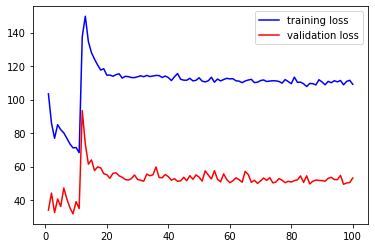

In [229]:
history = model.history
plot_loss_history(history)


In [228]:
import matplotlib.pyplot as plt

def plot_loss_history(history):
    epochs = history[:, 'epoch']
    training_losses = history[:, 'train_loss']
    validation_losses = history[:, 'valid_loss']
    plt.plot(epochs, training_losses, color='blue', label='training loss')
    plt.plot(epochs, validation_losses, color='red', label='validation loss')
    plt.legend()
    plt.show()

In [136]:
evaluate_autoencoder(model.module, test_data=train_data)

TypeError: AutoEncoder.predict() missing 1 required positional argument: 'x'

In [292]:
import pandas as pd
results = pd.DataFrame(grid_search.cv_results_)
results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr,param_max_epochs,param_module__activation_function,param_optimizer,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.102578,0.026118,0.000034,0.000000e+00,0.001,10,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
1,0.975618,0.035682,0.000038,3.933907e-06,0.001,10,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
2,0.926229,0.017654,0.000037,3.933907e-06,0.001,10,ReLU(),<class 'torch.optim.adam.Adam'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
3,0.731420,0.060926,0.000035,1.192093e-07,0.001,10,ReLU(),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.001, 'max_epochs': 10, 'module__activ...",0.7,0.7,0.7,0.0,1
4,1.251889,0.062733,0.000039,3.099442e-06,0.0001,10,GELU(approximate='none'),<class 'torch.optim.adam.Adam'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
5,0.847597,0.013039,0.000036,1.311302e-06,0.0001,10,GELU(approximate='none'),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
6,0.917123,0.003687,0.000060,1.537800e-05,0.0001,10,ReLU(),<class 'torch.optim.adam.Adam'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1
7,0.784601,0.020679,0.000040,5.960464e-07,0.0001,10,ReLU(),<class 'torch.optim.sgd.SGD'>,"{'lr': 0.0001, 'max_epochs': 10, 'module__acti...",0.7,0.7,0.7,0.0,1


In [380]:
print(grid_result.best_estimator_.module_)

AutoEncoder(
  (model): Sequential(
    (0): Linear(in_features=46, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): GELU(approximate='none')
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): GELU(approximate='none')
    (7): Linear(in_features=4, out_features=4, bias=True)
    (8): GELU(approximate='none')
    (9): Linear(in_features=4, out_features=8, bias=True)
    (10): GELU(approximate='none')
    (11): Linear(in_features=8, out_features=16, bias=True)
    (12): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): GELU(approximate='none')
    (14): Linear(in_features=16, out_features=46, bias=True)
    (15): GELU(approximate='none')
  )
)


In [112]:
evaluate_autoencoder(grid_result.best_estimator_, test_data=train_data)

AttributeError: 'numpy.ndarray' object has no attribute 'detach'

In [86]:
sorted(grid_result.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_lr',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [90]:
grid_result.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__module': __main__.AutoEncoder,
 'estimator__criterion': MSELoss(),
 'estimator__optimizer': torch.optim.sgd.SGD,
 'estimator__lr': 0.01,
 'estimator__max_epochs': 10,
 'estimator__batch_size': 32,
 'estimator__iterator_train': torch.utils.data.dataloader.DataLoader,
 'estimator__iterator_valid': torch.utils.data.dataloader.DataLoader,
 'estimator__dataset': skorch.dataset.Dataset,
 'estimator__train_split': <skorch.dataset.ValidSplit object at 0x142717e50>,
 'estimator__callbacks': None,
 'estimator__predict_nonlinearity': 'auto',
 'estimator__warm_start': False,
 'estimator__verbose': True,
 'estimator__device': 'cpu',
 'estimator___params_to_validate': {'iterator_train__batch_size',
  'iterator_train__shuffle',
  'iterator_valid__batch_size',
  'module__input_dim',
  'optimizer__lr'},
 'estimator__module__input_dim': 46,
 'estimator__optimizer__lr': 0.0001,
 'estimator__iterator_train__shuffle': True,
 'estimator__iterator_train__batch_size

In [79]:
grid_result.estimator

<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.AutoEncoder'>,
  module__input_dim=46,
)


In [82]:
print(grid_result)

GridSearchCV(cv=3,
             estimator=<class 'skorch.regressor.NeuralNetRegressor'>[uninitialized](
  module=<class '__main__.AutoEncoder'>,
  module__input_dim=46,
),
             n_jobs=1, param_grid={'lr': [0.001, 0.0001]}, verbose=True)


In [80]:
evaluate_autoencoder(grid_result.estimator, test_data=train_data)

NotInitializedError: This NeuralNetRegressor instance is not initialized yet. Call 'initialize' or 'fit' with appropriate arguments before using this method.

In [10]:
training_data, test_data, _ = DataProvider.get_flat_train_test_split(pi=PI, scaling_minmax=True, scale_normal_only=True)

rdf.columns: Index(['cpuUser', 'block:block_bio_remap', 'block:block_getrq',
       'block:block_unplug', 'fib:fib_table_lookup',
       'filemap:mm_filemap_add_to_page_cache', 'gpio:gpio_value',
       'ipi:ipi_raise', 'jbd2:jbd2_handle_start', 'kmem:kfree', 'kmem:kmalloc',
       'kmem:mm_page_alloc_zone_locked', 'kmem:mm_page_pcpu_drain',
       'mmc:mmc_request_start', 'net:net_dev_queue', 'net:net_dev_xmit',
       'net:netif_rx', 'page-faults', 'pagemap:mm_lru_insertion',
       'qdisc:qdisc_dequeue', 'random:get_random_bytes',
       'random:mix_pool_bytes_nolock', 'rpm:rpm_resume', 'rpm:rpm_suspend',
       'sched:sched_process_exec', 'sched:sched_process_free',
       'sched:sched_process_wait', 'signal:signal_deliver',
       'signal:signal_generate', 'skb:kfree_skb',
       'skb:skb_copy_datagram_iovec', 'task:task_newtask',
       'tcp:tcp_destroy_sock', 'tcp:tcp_probe', 'timer:timer_start',
       'workqueue:workqueue_activate_work',
       'writeback:sb_clear_inode_writeb

In [13]:
training_data1, test_data1, _ = DataProvider.get_scaled_train_test_split(pi=PI, scaling_minmax=True, scale_normal_only=False)

In [14]:
print(len(training_data1))

8


In [15]:
print(training_data.shape)
print(test_data.shape)

(37472, 47)
(11718, 47)
<class 'numpy.ndarray'>


In [14]:
print(experiment_path)

/Users/jankreischer/Library/Mobile Documents/com~apple~CloudDocs/Master-Thesis/Code/prototypes/prototype_02/experiments/experiment_01


In [ ]:
environment_01 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)
environment_02 = SensorEnvironment(train_data, interpreter=ae_interpreter, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND, parallelized=False)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

server.run_federation(verbosity=["performance_evaluation", "learning_curve"], evaluation_frequency=1)


# initialize memory replay buffer (randomly)
#SimulationEngine.init_replay_memory(agent=agent, env=env, min_size=MIN_REPLAY_SIZE)

# main training
#episode_returns, eps_history = SimulationEngine.learn_agent_offline(agent=agent, env=env, num_episodes=N_EPISODES,
#                                                                    t_update_freq=TARGET_UPDATE_FREQ)

#end = time()
#print("Total training time: ", end - start)

#num = 0
#agent.save_agent_state(num, experiment_base_dir)

#x = [i + 1 for i in range(N_EPISODES)]
#filename = f"{experiment_base_dir}/mtd_agent_p2_{SAMPLES}_sample.pdf"
#plot_learning(x, episode_returns, eps_history, filename)

# check predictions with dqn from trained and stored agent
#pretrained_agent = get_pretrained_agent(path=f"{experiment_base_dir}/trained_models/agent_{num}.pth",
#                                        input_dims=env.observation_space_size, n_actions=len(env.actions),
#                                        buffer_size=BUFFER_SIZE)

#evaluate_agent(pretrained_agent, test_data=test_data)

# print("evaluate p2 agent on 'real' decision and afterstate data:")
# dtrain, dtest, atrain, atest = DataProvider.get_reduced_dimensions_with_pca_ds_as(dims,
#                                                                                   dir="offline_prototype_2_raw_behaviors/")
# evaluate_agent(agent=pretrained_agent, test_data=dtest)
# evaluate_agent_on_afterstates(agent=pretrained_agent, test_data=atest)

In [11]:
import numpy as np
np.random.random_sample()

0.48782730785121353

In [9]:
autoencoder = AutoEncoder(initial_autoencoder_architecture(), ae_valid_x, ae_test_x, ae_test_y, evaluation_data)
autoencoder.pretrain(ae_train_x, optimizer=torch.optim.Adam(autoencoder.parameters(), lr=1e-4,  weight_decay=0.01), loss_function=RMSELoss(), num_epochs=100, batch_size=64, verbose=True)
autoencoder.evaluate(num_std=2.5, tablefmt='latex_raw')

NameError: name 'AutoEncoder' is not defined

In [8]:
from prototypes.prototype_02.experiment import Experiment
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

ae_path = f"{experiment_path}/ae_model_pi3.pth"
#ae_interpreter = get_pretrained_ae(path=ae_path, dims=46)


# Hyperparams

GAMMA = 0.1 #0.99 # discount factor for future rewards
BATCH_SIZE = 100
N_EPISODES = 10000

NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 1000

BUFFER_SIZE = 500
MIN_REPLAY_SIZE = 100
# Epsilon determining Exploration Exploitation Trade Off
EPSILON_START = 1.0
EPSILON_DEC = 1e-4 # 0.001
EPSILON_END = 0.01

TARGET_UPDATE_FREQ = 100
LEARNING_RATE = 1e-4
LOG_FREQ = 100
DIMS = 20
PI = 3
SAMPLES = 10

EPSILON_START = 1.0
EPSILON_DEC = 1e-3
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 100
N_SAMPLES = 1000

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

'''
sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

#print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
#print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
'''

environment = SensorEnvironment(training_data, interpreter=autoencoder, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment.observation_space_size, n_actions=len(environment.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

for i in range(1,11,1):
    environment = SensorEnvironment(training_data, interpreter=autoencoder, state_samples=SAMPLES)
    agent = Agent(i, input_dims=environment.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)
    client = Client(i, agent, environment, experiment_path, MIN_REPLAY_SIZE)
    server.add_client(client)


evaluations = [Evaluation.FINAL_LEARNING_CURVE, Evaluation.PERFORMANCE_EVALUATION]
server.run_federation(evaluations=evaluations, evaluation_frequency=10)

NameError: name 'autoencoder' is not defined

correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
exhausted all mtd techniques
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen accord

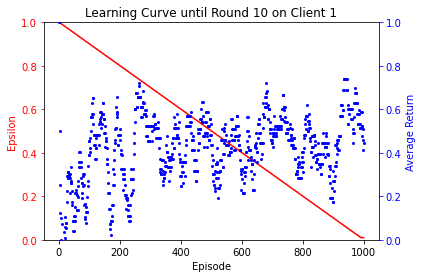

Agent 2 learning curve


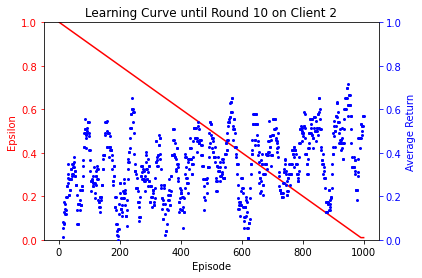

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.29 | ransomware_file_extension_hide |
| bdvl               |      89.73 | rootkit_sanitizer              |
| beurk              |       9.31 | rootkit_sanitizer              |
| the_tick           |      90.07 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      89.55 | cnc_ip_shuffle                 |
| data_leak_1        |      99.65 | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
PERFORMANCE EVALUATION
Agent 2 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.12 | ransomware_file_extension_hide |
| bdvl               |      99.47 | rootkit_sanitizer       

In [381]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

ae_path = f"{experiment_path}/ae_model_pi3.pth"
#ae_interpreter = get_pretrained_ae(path=ae_path, dims=46)

EPSILON_START = 1.0
EPSILON_DEC = 1e-3
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 100
N_SAMPLES = 1000

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

'''
sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

#print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
#print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
'''

environment_01 = SensorEnvironment(training_data, interpreter=autoencoder, state_samples=SAMPLES)
environment_02 = SensorEnvironment(training_data, interpreter=autoencoder, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

evaluations = [Evaluation.LEARNING_CURVE, Evaluation.PERFORMANCE_EVALUATION]
server.run_federation(evaluations=evaluations, evaluation_frequency=10)

correct mtd chosen according to supervisor
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
correct mtd chosen according to supervisor
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
Resetting to behavior: Behavior.CNC_OPT1
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to supervisor
correct mtd chosen according to super

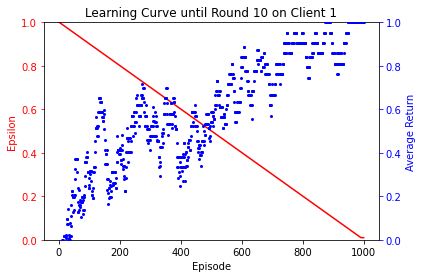

Agent 2 learning curve


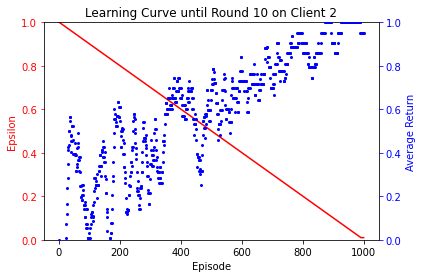

PERFORMANCE EVALUATION
Agent 1 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      98.55 | ransomware_file_extension_hide |
| bdvl               |      98.94 | rootkit_sanitizer              |
| beurk              |      69.68 | rootkit_sanitizer              |
| the_tick           |      26.19 | cnc_ip_shuffle                 |
| backdoor_jakoritar |      32.39 | cnc_ip_shuffle                 |
| data_leak_1        |     100    | cnc_ip_shuffle                 |
| data_leak_2        |     100    | cnc_ip_shuffle                 |
PERFORMANCE EVALUATION
Agent 2 > Performance Evaluation
| Behavior           |   Accuracy | Objective                      |
|:-------------------|-----------:|:-------------------------------|
| ransomware_poc     |      99.09 | ransomware_file_extension_hide |
| bdvl               |      98.94 | rootkit_sanitizer       

In [385]:
experiments = Experiment(original_working_directory_path)
experiment_id = 1
experiment_version = 0
experiment_path = experiments.get_experiment_path(experiment_id, experiment_version)

ae_path = f"{experiment_path}/ae_model_pi3.pth"
#ae_interpreter = get_pretrained_ae(path=ae_path, dims=46)

EPSILON_START = 1.0
EPSILON_DEC = 1e-3
EPSILON_END = 0.01
NR_ROUNDS = 10
NR_EPISODES_PER_ROUND = 100
N_SAMPLES = 1000

training_data, test_data, _ = DataProvider.get_scaled_train_test_split(scaling_minmax=True, scale_normal_only=True)

'''
sampling_probabilities_1 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

sampling_probabilities_2 = {
    #Behavior.NORMAL: 0,
    Behavior.ROOTKIT_BDVL: 1/7,
    Behavior.ROOTKIT_BEURK: 1/7,
    Behavior.CNC_BACKDOOR_JAKORITAR: 1/7,
    Behavior.CNC_THETICK: 1/7, 
    Behavior.CNC_OPT1: 1/7,
    Behavior.CNC_OPT2: 1/7,
    Behavior.RANSOMWARE_POC: 1/7
}

n_samples_1 = np.array(list(sampling_probabilities_1.values()))*N_SAMPLES
n_samples_2 = np.array(list(sampling_probabilities_2.values()))*N_SAMPLES

sample_matrix = np.vstack([n_samples_1, n_samples_2])

#print(f"MID: {multiclass_imbalance_degree(sample_matrix)}")
#print(f"WCS: {weighted_cosine_similarity(sample_matrix)}")
'''

environment_01 = SensorEnvironment(training_data, interpreter=initial_autoencoder, state_samples=SAMPLES)
environment_02 = SensorEnvironment(training_data, interpreter=initial_autoencoder, state_samples=SAMPLES)

global_agent = Agent(0, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_01 = Agent(1, input_dims=environment_01.observation_space_size, n_actions=len(environment_01.actions), buffer_size=BUFFER_SIZE,
              batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

agent_02 = Agent(2, input_dims=environment_02.observation_space_size, n_actions=len(environment_02.actions), buffer_size=BUFFER_SIZE,
                batch_size=BATCH_SIZE, lr=LEARNING_RATE, gamma=GAMMA, epsilon=EPSILON_START, eps_end=EPSILON_END, eps_dec=EPSILON_DEC)

server = Server(global_agent, test_data, experiment_id, experiment_path, nr_rounds=NR_ROUNDS, nr_episodes_per_round=NR_EPISODES_PER_ROUND)

client_01 = Client(1, agent_01, environment_01, experiment_path, MIN_REPLAY_SIZE)
client_02 = Client(2, agent_02, environment_02, experiment_path, MIN_REPLAY_SIZE)

server.add_client(client_01)
server.add_client(client_02)

evaluations = [Evaluation.LEARNING_CURVE, Evaluation.PERFORMANCE_EVALUATION]
server.run_federation(evaluations=evaluations, evaluation_frequency=10)